# 01 前情摘要

前面的task2与task3讲解了音频数据的分析以及特征提取等内容，本次任务主要是讲解CNN模型的搭建与训练，由于模型训练需要用到之前的特侦提取等得让，于是在此再贴一下相关代码。

## 1.1 导包

In [1]:
#基本库
import pandas as pd
import numpy as np
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

#深度学习框架
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, Dropout
from tensorflow.keras.utils import to_categorical 
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import tensorflow as tf
import tensorflow.keras

#音频处理库
import os
import librosa
import librosa.display
import glob 

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## 1.2 特征提取以及数据集的建立

In [2]:
feature = []
label = []
# 建立类别标签，不同类别对应不同的数字。
label_dict = {'aloe': 0, 'burger': 1, 'cabbage': 2,'candied_fruits':3, 'carrots': 4, 'chips':5,
                  'chocolate': 6, 'drinks': 7, 'fries': 8, 'grapes': 9, 'gummies': 10, 'ice-cream':11,
                  'jelly': 12, 'noodles': 13, 'pickles': 14, 'pizza': 15, 'ribs': 16, 'salmon':17,
                  'soup': 18, 'wings': 19}
label_dict_inv = {v:k for k,v in label_dict.items()}

建立提取音频特征的函数

In [3]:
from tqdm import tqdm
def extract_features(parent_dir, sub_dirs, max_file=10, file_ext="*.wav"):
    c = 0
    label, feature = [], []
    for sub_dir in sub_dirs:
        for fn in tqdm(glob.glob(os.path.join(parent_dir, sub_dir, file_ext))[:max_file]): # 遍历数据集的所有文件
            
           # segment_log_specgrams, segment_labels = [], []
            #sound_clip,sr = librosa.load(fn)
            #print(fn)
            label_name = fn.split('/')[-2]
            label.extend([label_dict[label_name]])
            X, sample_rate = librosa.load(fn,res_type='kaiser_fast')
            mels = np.mean(librosa.feature.melspectrogram(y=X,sr=sample_rate).T,axis=0) # 计算梅尔频谱(mel spectrogram),并把它作为特征
            feature.extend([mels])
            
    return [feature, label]

In [4]:
# 自己更改目录
parent_dir = './train_sample/'
save_dir = "./"
folds = sub_dirs = np.array(['aloe','burger','cabbage','candied_fruits',
                             'carrots','chips','chocolate','drinks','fries',
                            'grapes','gummies','ice-cream','jelly','noodles','pickles',
                            'pizza','ribs','salmon','soup','wings'])

# 获取特征feature以及类别的label
temp = extract_features(parent_dir,sub_dirs,max_file=100)

100%|██████████| 35/35 [00:10<00:00,  2.80it/s]


In [5]:
temp = np.array(temp)
data = temp.transpose()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [6]:
# 获取特征
X = np.vstack(data[:, 0])

# 获取标签
Y = np.array(data[:, 1])
print('X的特征尺寸是：',X.shape)
print('Y的特征尺寸是：',Y.shape)

X的特征尺寸是： (1000, 128)
Y的特征尺寸是： (1000,)


In [7]:
# 在Keras库中：to_categorical就是将类别向量转换为二进制（只有0和1）的矩阵类型表示
Y = to_categorical(Y)

In [8]:
'''最终数据'''
print(X.shape)
print(Y.shape)

(1000, 128)
(1000, 20)


In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = 1, stratify=Y)
print('训练集的大小',len(X_train))
print('测试集的大小',len(X_test))

训练集的大小 750
测试集的大小 250


In [10]:
X_train = X_train.reshape(-1, 16, 8, 1)
X_test = X_test.reshape(-1, 16, 8, 1)

# 02 建立模型

## 2.1 深度学习框架

Keras 是一个用 Python 编写的高级神经网络 API，它能够以 TensorFlow, CNTK, 或者 Theano 作为后端运行。现在Keras已经和TensorFlow合并，可以通过TensorFlow来调用。

### 2.1.1 网络结构搭建

Keras 的核心数据结构是 model，一种组织网络层的方式。最简单的模型是 Sequential 顺序模型，它由多个网络层线性堆叠。对于更复杂的结构，你应该使用 Keras 函数式 API，它允许构建任意的神经网络图。

Sequential模型可以直接通过如下方式搭建：

from keras.models import Sequential

model = Sequential()

In [11]:
model = Sequential()

### 2.1.2 搭建CNN网络

In [12]:
# 输入的大小
input_dim = (16, 8, 1)

### 2.1.3 CNN基础知识

> 推荐的资料中，我们推荐大家去看看李宏毅老师的讲的[CNN网络](https://www.youtube.com/watch?v=FrKWiRv254g&feature=youtu.be)这里也附上老师的[PPT](http://speech.ee.ntu.edu.tw/~tlkagk/courses/ML_2017/Lecture/CNN.pdf)。

CNN网络的基本架构

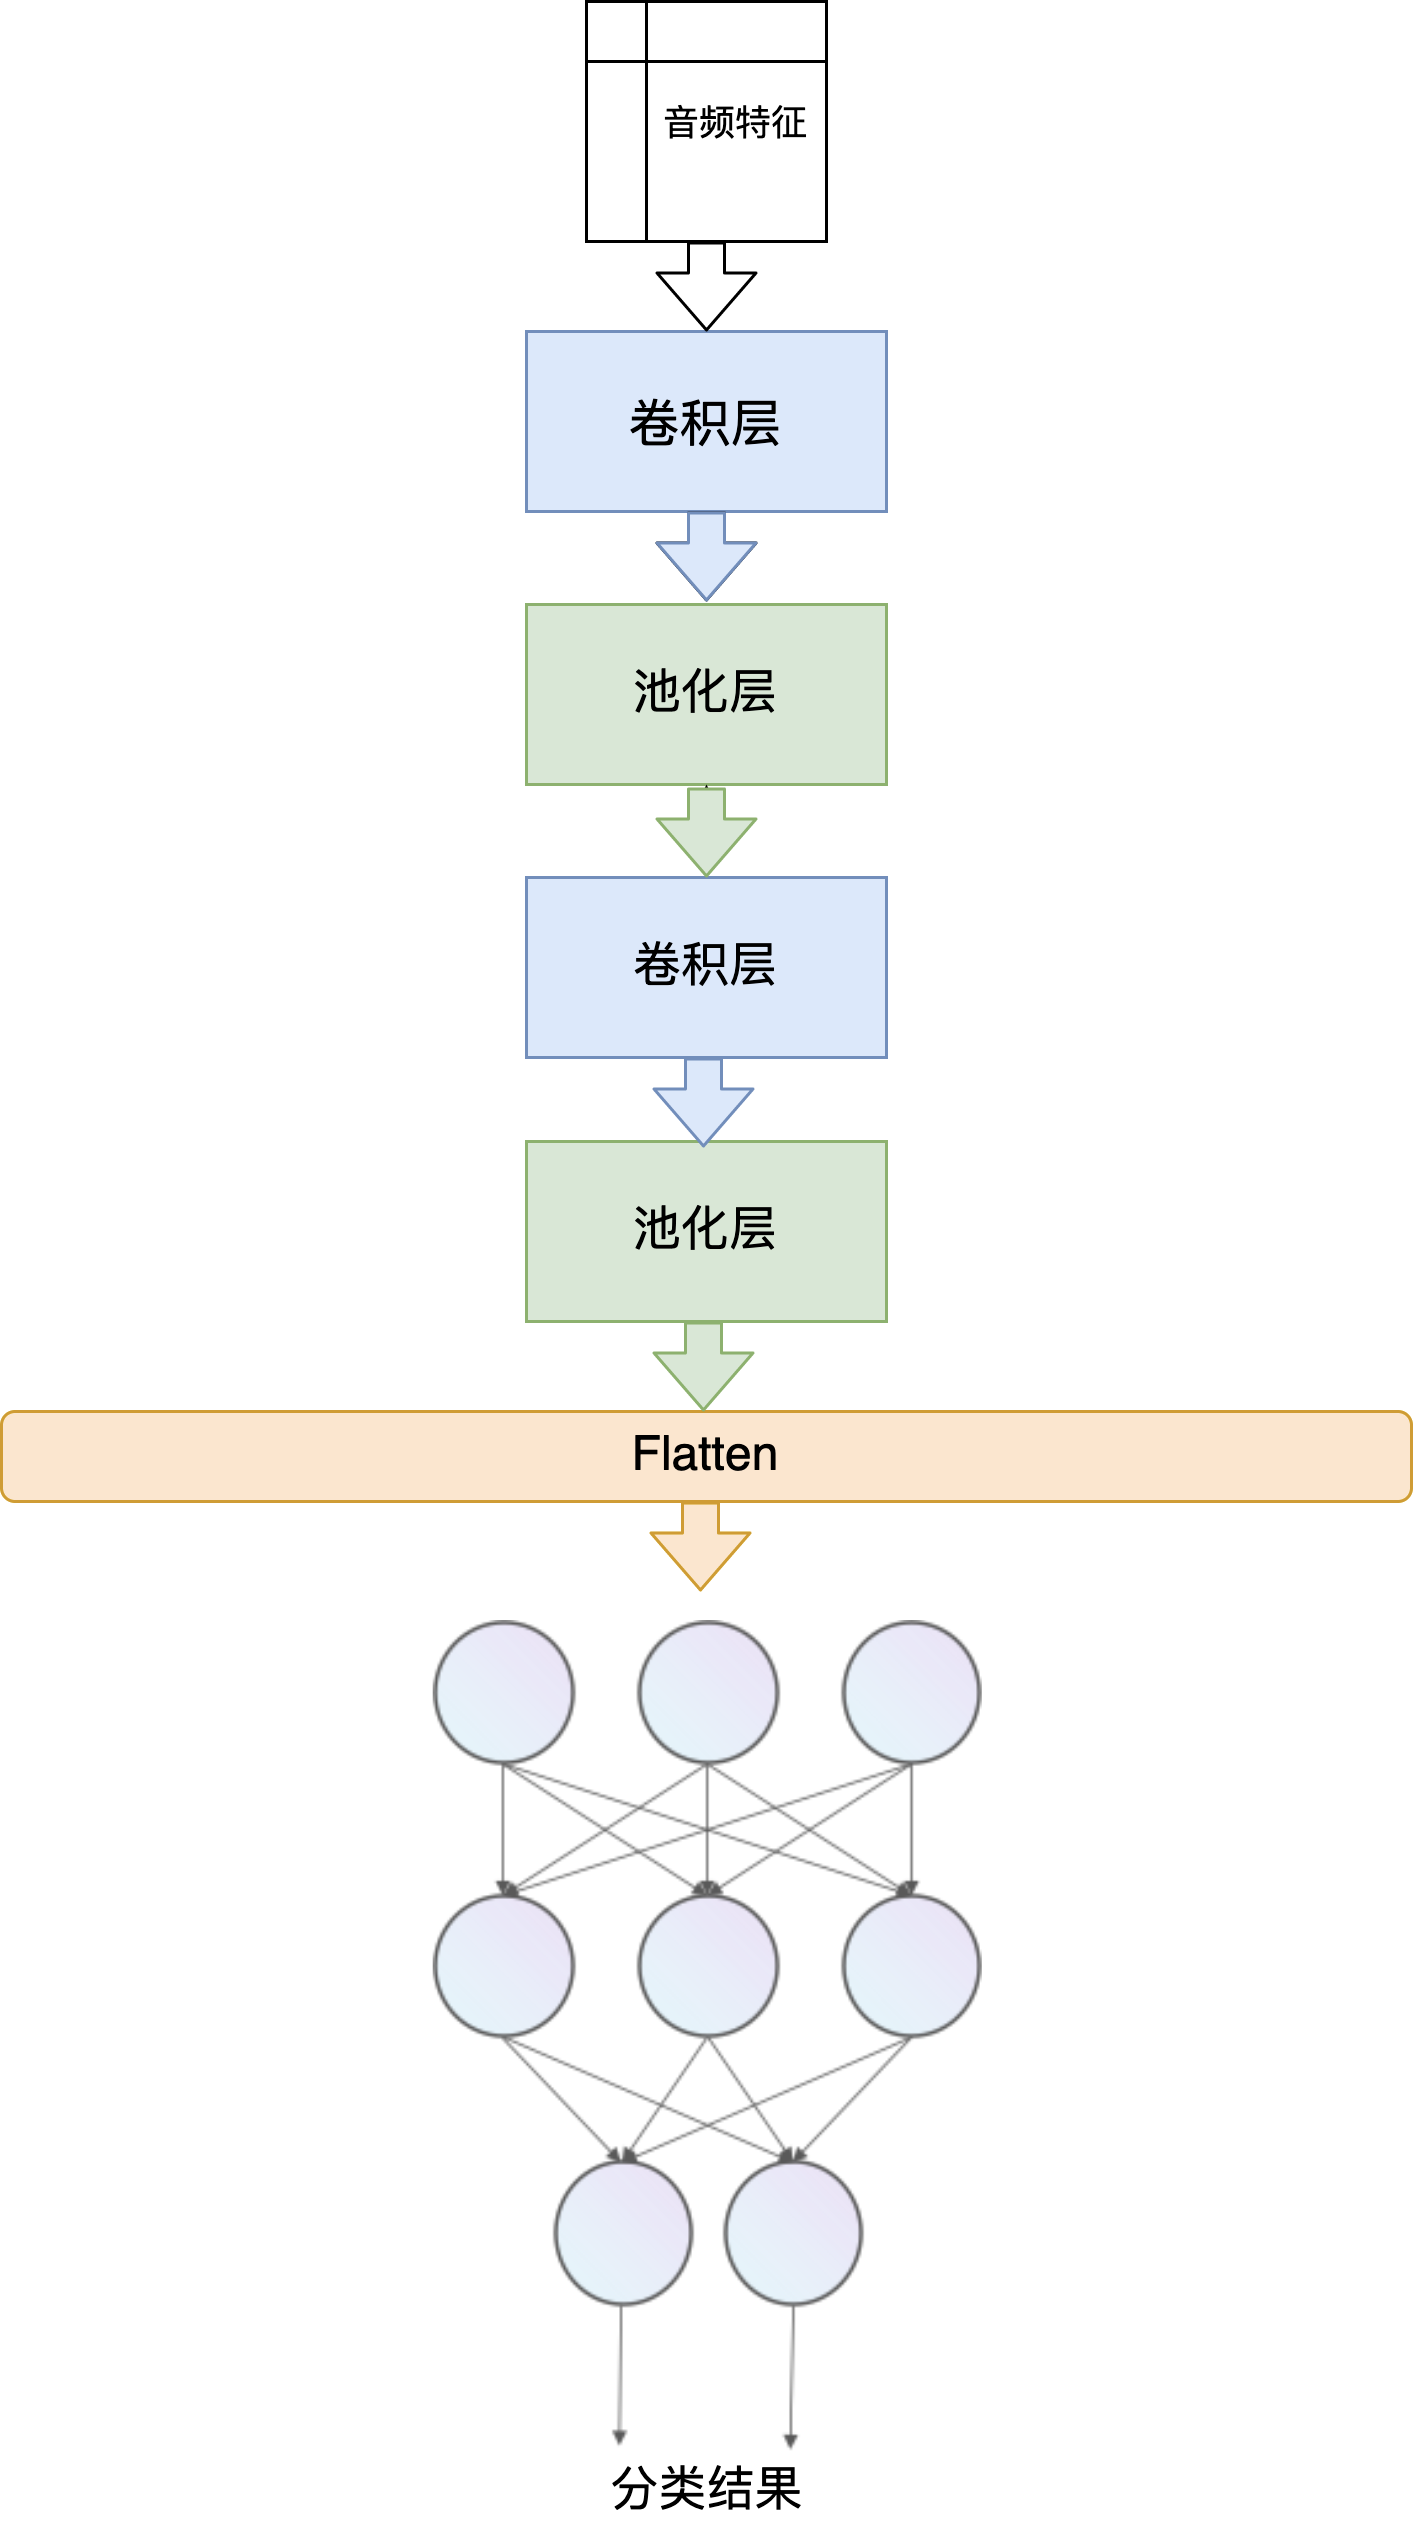

卷积神经网络CNN的结构一般包含这几个层：

1)输入层：用于数据的输入

2)卷积层：使用卷积核进行特征提取和特征映射------>可以多次重复使用

3)激励层：由于卷积也是一种线性运算，因此需要增加非线性映射(也就是激活函数)

4)池化层：进行下采样，对特征图稀疏处理，减少数据运算量----->可以多次重复使用

5）Flatten操作：将二维的向量，拉直为一维的向量，从而可以放入下一层的神经网络中

6)全连接层：通常在CNN的尾部进行重新拟合，减少特征信息的损失----->DNN网络

对于Keras操作中，可以简单地使用 `.add()` ，将需要搭建的神经网络的layer堆砌起来，像搭积木一样：

In [13]:
model.add(Conv2D(64, (3, 3), padding = "same", activation = "tanh", input_shape = input_dim))# 卷积层
model.add(MaxPool2D(pool_size=(2, 2)))# 最大池化
model.add(Conv2D(128, (3, 3), padding = "same", activation = "tanh")) #卷积层
model.add(MaxPool2D(pool_size=(2, 2))) # 最大池化层
model.add(Dropout(0.1))
model.add(Flatten()) # 展开
model.add(Dense(1024, activation = "tanh"))
model.add(Dense(20, activation = "softmax")) # 输出层：20个units输出20个类的概率

如果需要，你还可以进一步地配置你的优化器`.complies()`)。Keras 的核心原则是使事情变得相当简单，同时又允许用户在需要的时候能够进行完全的控制（终极的控制是源代码的易扩展性）。

In [14]:
# 编译模型，设置损失函数，优化方法以及评价标准
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# 03 CNN模型训练与测试

## 3.1 模型训练
批量的在之前搭建的模型上训练：

In [15]:
# 训练模型
model.fit(X_train, Y_train, epochs = 90, batch_size = 50, validation_data = (X_test, Y_test))

Epoch 1/90
15/15 [==============================] - 4s 162ms/step - loss: 2.9158 - accuracy: 0.1150 - val_loss: 2.7704 - val_accuracy: 0.1360
Epoch 2/90
15/15 [==============================] - 1s 79ms/step - loss: 2.5593 - accuracy: 0.2049 - val_loss: 2.5741 - val_accuracy: 0.2080
Epoch 3/90
15/15 [==============================] - 1s 81ms/step - loss: 2.2751 - accuracy: 0.3186 - val_loss: 2.4504 - val_accuracy: 0.2520
Epoch 4/90
15/15 [==============================] - 1s 73ms/step - loss: 2.1422 - accuracy: 0.3405 - val_loss: 2.3872 - val_accuracy: 0.2680
Epoch 5/90
15/15 [==============================] - 1s 76ms/step - loss: 1.9961 - accuracy: 0.3965 - val_loss: 2.3609 - val_accuracy: 0.2680
Epoch 6/90
15/15 [==============================] - 1s 81ms/step - loss: 1.8838 - accuracy: 0.4284 - val_loss: 2.4414 - val_accuracy: 0.2800
Epoch 7/90
15/15 [==============================] - 1s 78ms/step - loss: 1.8825 - accuracy: 0.4246 - val_loss: 2.3338 - val_accuracy: 0.3000
Epoch 8/90
1

查看网络的统计信息

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 8, 64)         640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 4, 64)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 4, 128)         73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 2, 128)         0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 2, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1

## 3.2 预测测试集

新的数据生成预测

In [19]:
def extract_features(test_dir, file_ext="*.wav"):
    feature = []
    for fn in tqdm(glob.glob(os.path.join(test_dir, file_ext))[:]): # 遍历数据集的所有文件
        X, sample_rate = librosa.load(fn,res_type='kaiser_fast')
        mels = np.mean(librosa.feature.melspectrogram(y=X,sr=sample_rate).T,axis=0) # 计算梅尔频谱(mel spectrogram),并把它作为特征
        feature.extend([mels])
    return feature

保存预测的结果

In [20]:
X_test = extract_features('./test_a/')

100%|██████████| 2000/2000 [10:13<00:00,  3.56it/s]


In [21]:
X_test = np.vstack(X_test)
predictions = model.predict(X_test.reshape(-1, 16, 8, 1))

In [22]:
preds = np.argmax(predictions, axis = 1)
preds = [label_dict_inv[x] for x in preds]

path = glob.glob('./test_a/*.wav')
result = pd.DataFrame({'name':path, 'label': preds})

result['name'] = result['name'].apply(lambda x: x.split('/')[-1])
result.to_csv('submit.csv',index=None)

In [23]:
!ls ./test_a/*.wav | wc -l

2000


In [24]:
!wc -l submit.csv

2001 submit.csv
